<a href="https://colab.research.google.com/github/vidyacheekuri/corrosion-prediction-project/blob/main/notebooks/Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1: Imports**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor

**2: Load Dataset**

In [ ]:
# Load your dataset
df = pd.read_csv("Corrosion_Dataset_processed.csv")

**3: Feature Engineering**

In [ ]:
# Add interaction features
df["Humidity_Temp"] = df["Relative_Humidity_pct"] * df["Temperature_K"]
df["Cement_Cover"] = df["Water_Cement_Ratio"] * df["Cover_Thickness_mm"]

**4: Virtual Sample Generation (VSG)**

In [ ]:
# Identify rare samples based on low corrosion rate
threshold = df["Corrosion_Rate_uAcm2"].quantile(0.25)
rare = df[df["Corrosion_Rate_uAcm2"] < threshold]
numeric = [
    "Cover_Thickness_mm", "Reinforcement_Diameter_mm", "Water_Cement_Ratio",
    "Temperature_K", "Relative_Humidity_pct", "Chloride_Ion_Content_kgm3", "Time_Years"
]

synth = rare.sample(n=100, replace=True, random_state=42).copy()
synth[numeric] += np.random.normal(0, 0.01, size=synth[numeric].shape)

synth["Humidity_Temp"] = synth["Relative_Humidity_pct"] * synth["Temperature_K"]
synth["Cement_Cover"] = synth["Water_Cement_Ratio"] * synth["Cover_Thickness_mm"]

df = pd.concat([df, synth], ignore_index=True)

**5: Train-Test Split**

In [ ]:
X = df.drop(columns=["Corrosion_Rate_uAcm2"])
y = df["Corrosion_Rate_uAcm2"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

imp = SimpleImputer(strategy="median")
X_train = pd.DataFrame(imp.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(imp.transform(X_test), columns=X.columns)

# === Reset y_train/y_test indices to match ===
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

**6: Define and Train Models**

In [ ]:
# Segmented Modeling (Low vs High Target)
low_mask = y_train < 0.15
high_mask = y_train >= 0.15

model_low = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
model_high = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)

model_low.fit(X_train[low_mask], y_train[low_mask])
model_high.fit(X_train[high_mask], y_train[high_mask])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

**7: Predictions & Evaluation**

In [ ]:
y_pred = []
for i in range(len(X_test)):
    x = X_test.iloc[i:i+1]
    if y_test.iloc[i] < 0.15:
        pred = model_low.predict(x)[0]
    else:
        pred = model_high.predict(x)[0]
    y_pred.append(pred)
y_pred = np.array(y_pred)

r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
error_pct = np.abs((y_test - y_pred) / y_test) * 100
within_10 = (error_pct < 10).mean() * 100
within_5 = (error_pct < 5).mean() * 100

print("🔀 Segmented XGBoost Model")
print(f"✅ R² Score      : {r2:.3f}")
print(f"📉 RMSE          : {rmse:.4f}")
print(f"📉 MAE           : {mae:.4f}")
print(f"🎯 ≤10% Error    : {within_10:.2f}%")
print(f"🎯 ≤5% Error     : {within_5:.2f}%")

🔀 Segmented XGBoost Model
✅ R² Score      : 0.902
📉 RMSE          : 0.0013
📉 MAE           : 0.0227
🎯 ≤10% Error    : 57.14%
🎯 ≤5% Error     : 34.69%


**8: Plot Predictions**

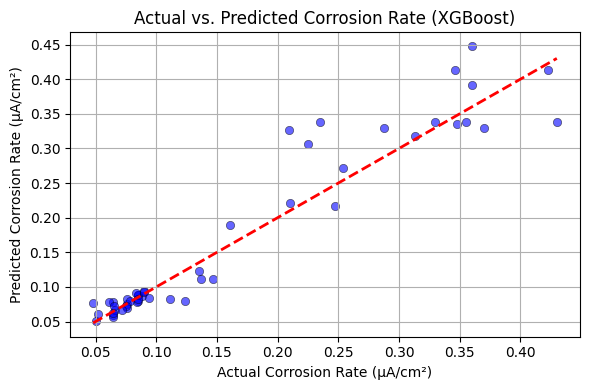

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of predicted vs. actual
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_test, y=y_pred, color="blue", alpha=0.6, edgecolor="k")

# 45-degree line for perfect predictions
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

plt.xlabel("Actual Corrosion Rate (μA/cm²)")
plt.ylabel("Predicted Corrosion Rate (μA/cm²)")
plt.title("Actual vs. Predicted Corrosion Rate (XGBoost)")
plt.grid(True)
plt.tight_layout()
plt.show()

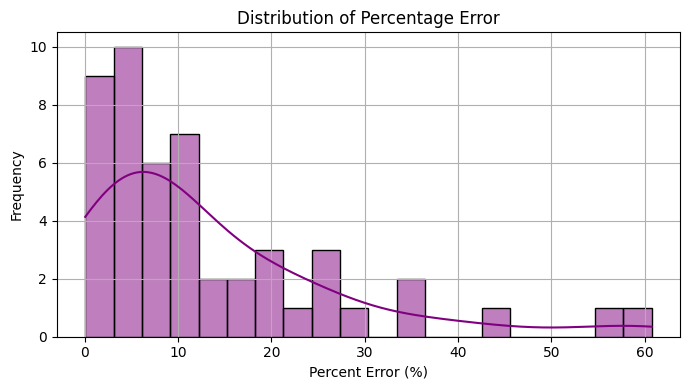

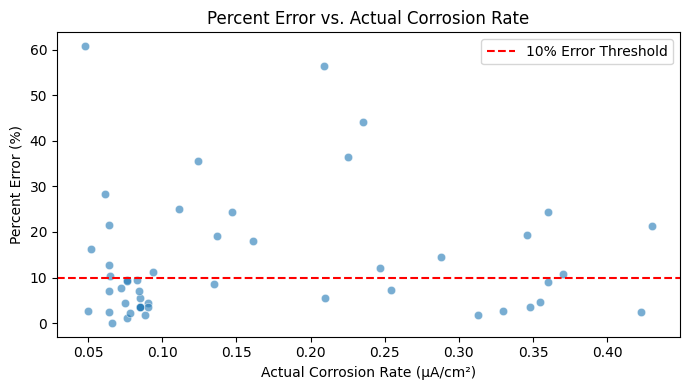

Mean Percent Error    : 13.39%
Median Percent Error  : 8.96%
Samples ≤ 5% Error     : 34.69%
Samples ≤ 10% Error    : 57.14%
Samples ≤ 30% Error    : 89.80%


In [ ]:
# === Error Analysis ===

import seaborn as sns

# Create a DataFrame with actual and predicted values
error_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred
})
error_df["Absolute_Error"] = np.abs(error_df["Actual"] - error_df["Predicted"])
error_df["Percent_Error"] = 100 * error_df["Absolute_Error"] / error_df["Actual"]

# === 1. Distribution of Percent Error ===
plt.figure(figsize=(7, 4))
sns.histplot(error_df["Percent_Error"], bins=20, kde=True, color="purple")
plt.title("Distribution of Percentage Error")
plt.xlabel("Percent Error (%)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 2. Error vs. Actual Corrosion Rate ===
plt.figure(figsize=(7, 4))
sns.scatterplot(x=error_df["Actual"], y=error_df["Percent_Error"], alpha=0.6)
plt.axhline(y=10, color='red', linestyle='--', label="10% Error Threshold")
plt.xlabel("Actual Corrosion Rate (µA/cm²)")
plt.ylabel("Percent Error (%)")
plt.title("Percent Error vs. Actual Corrosion Rate")
plt.legend()
plt.tight_layout()
plt.show()

# === 3. Error Summary ===
within_5 = np.mean(error_df["Percent_Error"] <= 5) * 100
within_10 = np.mean(error_df["Percent_Error"] <= 10) * 100
within_30 = np.mean(error_df["Percent_Error"] <= 30) * 100
mean_error = error_df["Percent_Error"].mean()
median_error = error_df["Percent_Error"].median()

print(f"Mean Percent Error    : {mean_error:.2f}%")
print(f"Median Percent Error  : {median_error:.2f}%")
print(f"Samples ≤ 5% Error     : {within_5:.2f}%")
print(f"Samples ≤ 10% Error    : {within_10:.2f}%")
print(f"Samples ≤ 30% Error    : {within_30:.2f}%")

In [ ]:
# --- User Input & Prediction Script ---

import pandas as pd

# 1. Prompt user for each feature
cover_mm        = float(input("Enter cover thickness (mm): "))
diameter_mm     = float(input("Enter reinforcement diameter (mm): "))
wcr             = float(input("Enter water–cement ratio (e.g. 0.40): "))
temp_K          = float(input("Enter temperature (K): "))
rh_pct          = float(input("Enter relative humidity (%): "))
chloride_kgm3   = float(input("Enter chloride ion content (kg/m³): "))
time_years      = float(input("Enter exposure time (years): "))

# 2. Build a single‐row DataFrame
df_input = pd.DataFrame([{
    "Cover_Thickness_mm":        cover_mm,
    "Reinforcement_Diameter_mm": diameter_mm,
    "Water_Cement_Ratio":        wcr,
    "Temperature_K":             temp_K,
    "Relative_Humidity_pct":     rh_pct,
    "Chloride_Ion_Content_kgm3": chloride_kgm3,
    "Time_Years":                time_years
}])

# 3. Recompute interaction features
df_input["Cement_Cover"] = df_input["Cover_Thickness_mm"] * df_input["Water_Cement_Ratio"]
df_input["Humidity_Temp"]   = df_input["Relative_Humidity_pct"] * df_input["Temperature_K"]

# 4. Impute (using your trained imputer) and select model inputs
X_input = pd.DataFrame(
    imp.transform(df_input[X_train.columns]),  # imp and X_train.columns must be defined from your pipeline
    columns=X_train.columns
)

# 5. Make predictions with both segmented models
pred_low  = model_low .predict(X_input)[0]
pred_high = model_high.predict(X_input)[0]

# 6. Display results
print(f"\nPredicted corrosion rate if in LOW-rate segment:  {pred_low:.3f} µA/cm²")
print(f"Predicted corrosion rate if in HIGH-rate segment: {pred_high:.3f} µA/cm²")

Enter cover thickness (mm): 43
Enter reinforcement diameter (mm): 26
Enter water–cement ratio (e.g. 0.40): 0.35
Enter temperature (K): 300
Enter relative humidity (%): 65
Enter chloride ion content (kg/m³): 6
Enter exposure time (years): 12

Predicted corrosion rate if in LOW-rate segment:  0.084 µA/cm²
Predicted corrosion rate if in HIGH-rate segment: 0.318 µA/cm²


In [ ]:
def predict_segmented(X_new, threshold=0.15):

    # 1. Get both segment predictions
    pred_low  = model_low .predict(X_new)
    pred_high = model_high.predict(X_new)

    # 2. Choose low-model prediction whenever it’s below (or equal) to the threshold;
    #    otherwise choose high-model prediction.
    final_pred = np.where(pred_low <= threshold, pred_low, pred_high)

    return final_pred

single_pred = predict_segmented(X_input, threshold=0.15)
print(f"Final segmented prediction: {single_pred[0]:.3f} µA/cm²")

Final segmented prediction: 0.084 µA/cm²
